In [33]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
from snorkel.learning.pytorch import LSTM
from matplotlib import pyplot as plt
import plotnine as pn
import dotenv
dotenv.load_dotenv('../env.sh')
%matplotlib inline
%run ../src/supervision.py
session = SnorkelSession()

article_data_files = [
    osp.join(os.environ['IMPORT_DATA_DIR_01'], 'data.csv'),
    osp.join(os.environ['IMPORT_DATA_DIR_02'], 'data.csv')
]

# TODO:
# - top and bottom examples for each relation
# - top cytokines/tfs by cell type and paper count
# - top cytokines by cell type from immuneXpresso for comparison
# - top cytokines per cell type over time

## Generate Predictions

In [3]:
classes = get_candidate_classes()

res_pred = {}
split = SPLIT_TRAIN

for c in classes:
    candidate_class = classes[c]
    X = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == split).all()
    
    lstm = LSTM()
    lstm.load('lstm_' + candidate_class.field, osp.join(os.environ['MODEL_DATA_DIR'], 'lstm'))

    Y = lstm.marginals(X)
    res_pred[c] = X, Y, lstm

[LSTM] Loaded model <lstm_inducing_cytokine>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Loaded model <lstm_secreted_cytokine>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Loaded model <lstm_inducing_transcription_factor>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


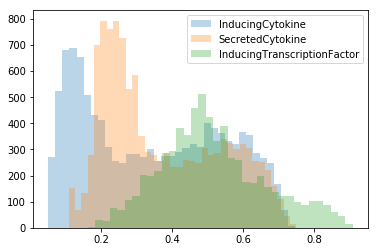

In [7]:
for c in res_pred:
    plt.hist(res_pred[c][1], label=c, bins=36, alpha=.3)
    plt.legend()

### Add Predictions to Candidates

In [35]:
df_ck = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cytokines.csv'))
df_ct = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cell_types.csv'))
df_tf = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'transcription_factors.csv'))

m_ct = df_ct.set_index('prefid')['lbl'].to_dict()
m_ck = df_ck.set_index('prefid')['lbl'].to_dict()
m_tf = df_tf.set_index('prefid')['lbl'].to_dict()

# Load doc id -> publishing date dict
m_doc_dt = {
    k: v
    for f in article_data_files
    for k, v in pd.read_csv(f, usecols=['id', 'date'])
    .assign(id=lambda df: 'PMC' + df['id'].astype(str))
    .pipe(lambda df: df[df['date'].notnull()])
    .assign(date=lambda df: pd.to_datetime(df['date']))
    .set_index('id')['date'].to_dict().items()
}

In [36]:
def to_record(cls, c, i, X, Y):
    assert len(X) == len(Y)
    candidate_class = classes[cls]
    typs = candidate_class.entity_types
    m1, m2 = {}, m_ct
    if typs[0] == ENT_TYP_CK.lower():
        m1 = m_ck
    elif typs[0] == ENT_TYP_TF.lower():
        m1 = m_tf
    else:
        raise ValueError('Type "{}" not supported'.format(typs[0]))
    ent1_cid = getattr(c, typs[0] + '_cid')
    ent2_cid = getattr(c, typs[1] + '_cid')
    doc_id = c.get_parent().get_parent().name
    return {
        'type': candidate_class.field, 
        'date': m_doc_dt.get(doc_id, None),
        'doc_id': doc_id, 
        'candidate_id': c.id, 
        'ent1_text': getattr(c, typs[0]).get_span(),
        'ent1_lbl': m1.get(ent1_cid.split(':')[1], None),
        'ent1_cid': ent1_cid, 
        'ent2_text': getattr(c, typs[1]).get_span(),
        'ent2_lbl': m2.get(ent2_cid.split(':')[1], None),
        'ent2_cid': ent2_cid,
        'prob': Y[i]
    }

df = pd.DataFrame([
    to_record(cls, cand, i, res_pred[cls][0], res_pred[cls][1]) 
    for cls in res_pred
    for i, cand in enumerate(res_pred[cls][0])
])
df.head()

,candidate_id,date,doc_id,ent1_cid,ent1_lbl,ent1_text,ent2_cid,ent2_lbl,ent2_text,prob,type
0,1,2012-04-27,PMC3376453,CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707,IL-4,IL-4,CTE7B12DC660323A0E:CTE7B12DC660323A0E,Th2,Th2,0.689861,inducing_cytokine
1,2,2016-12-03,PMC5321676,CK8074B95EB01901B1:CK128EC732B281BF60,IFN-γ,IFNγ,CTC3A8C3CBC245616A:CTC3A8C3CBC245616A,Th1,Th1,0.378053,inducing_cytokine
2,3,2017-12-10,PMC6083814,CKA197B6F7EC55F6D2:CK3FDAFD137F96385F,IL-22,IL-21,CTC3A8C3CBC245616A:CTC3A8C3CBC245616A,Th1,Th1,0.702274,inducing_cytokine
3,4,2017-12-10,PMC6083814,CKA197B6F7EC55F6D2:CK3FDAFD137F96385F,IL-22,IL-21,CTBFBDE5121B6748D1:CTBFBDE5121B6748D1,Th17,Th17,0.702124,inducing_cytokine
4,5,NaT,PMC4183221,CK82326B8893D0ED95:CKFD4CA0B2B4BC3AE4,TGF-β,TGF–β,CT954E3C2D0B390922:CTE9F6070561C95355,Tfh,TFH,0.566213,inducing_cytokine


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30166 entries, 0 to 30165
Data columns (total 11 columns):
candidate_id    30166 non-null int64
date            23766 non-null datetime64[ns]
doc_id          30166 non-null object
ent1_cid        30166 non-null object
ent1_lbl        30166 non-null object
ent1_text       30166 non-null object
ent2_cid        30166 non-null object
ent2_lbl        30166 non-null object
ent2_text       30166 non-null object
prob            30166 non-null float64
type            30166 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 2.5+ MB


In [38]:
df['type'].value_counts()

inducing_cytokine                11735
secreted_cytokine                11735
inducing_transcription_factor     6696
Name: type, dtype: int64

In [39]:
df['ent2_lbl'].value_counts().sort_values().tail()

Tfh     1592
Th2     4389
Th1     4709
Treg    4863
Th17    6926
Name: ent2_lbl, dtype: int64

In [40]:
df['ent1_lbl'].value_counts().sort_values().tail()

FOXP3    1656
IL-10    1880
IL-4     2550
TGF-β    2662
IFN-γ    2824
Name: ent1_lbl, dtype: int64

## Top Examples by Relation

In [103]:
def get_sentence_html(c, p=None):
    text = c.get_parent().text
    ctx = sorted(c.get_contexts(), key=lambda v: v.char_start)
    c0 = ctx[0].char_start, ctx[0].char_end+1
    c1 = ctx[1].char_start, ctx[1].char_end+1
    assert c0[0] < c1[0] and c0[1] < c1[0]
    
    parts = []
    if p is not None:
        parts += ['<a style="background-color: white">{:.2f}%|&nbsp;</a>'.format(p*100)]
    parts += [
        text[:c0[0]], '<font color="red"><strong>' + text[c0[0]:c0[1]] + '</strong></font>',
        text[c0[1]:c1[0]], '<font color="blue"><strong>' + text[c1[0]:c1[1]] + '</strong></font>',
        text[c1[1]:]
    ]
    return ''.join(parts)

In [118]:
from IPython.display import HTML, display

def get_prediction_html(index, X, Y, limit):
    html = []
    sent_ids = set()
    for i in index:
        sent_id = X[i].get_parent().id
        if sent_id in sent_ids:
            continue
        sent_ids.add(sent_id)
        html.append(get_sentence_html(X[i], p=Y[i]))
        if len(html) >= limit:
            break
    return HTML('<br>'.join(html))
    
limit = 15
for c in res_pred:
    X, Y = res_pred[c][:2]
    o = np.argsort(Y)
    
    display(HTML('<hr>'))
    print('%s (Top %s Highest Predictions):' % (c, limit))
    display(get_prediction_html(o[::-1], X, Y, limit))
    
    display(HTML('<hr>'))
    print('%s (Bottom %s Lowest Predictions):' % (c, limit))
    display(get_prediction_html(o, X, Y, limit))

InducingCytokine (Top 15 Highest Predictions):


InducingCytokine (Bottom 15 Lowest Predictions):


SecretedCytokine (Top 15 Highest Predictions):


SecretedCytokine (Bottom 15 Lowest Predictions):


InducingTranscriptionFactor (Top 15 Highest Predictions):


InducingTranscriptionFactor (Bottom 15 Lowest Predictions):


In [ ]:
# from snorkel import viewer
# idx = np.argsort(Y)
# idx = idx[-100:]
# viewer.SentenceNgramViewer(
#     candidates=[X[i] for i in idx], 
#     session=session
# )

## Top Cytokines/TFs by Cell Type

In [156]:
dfp = (
    df.query('prob > .5')
    .groupby(['ent2_lbl', 'ent1_lbl', 'type'])['doc_id'].nunique().rename('uniq_doc_ct').reset_index()
    .groupby('ent2_lbl', group_keys=False).apply(lambda g: g.sort_values('uniq_doc_ct', ascending=False).head(15))
)
dfp.head()

,ent2_lbl,ent1_lbl,type,uniq_doc_ct
2,IEL,IL-15,inducing_cytokine,2
4,IEL,IRF6,inducing_transcription_factor,2
0,IEL,CCL25,inducing_cytokine,1
1,IEL,IL-10,secreted_cytokine,1
3,IEL,IL-2,inducing_cytokine,1


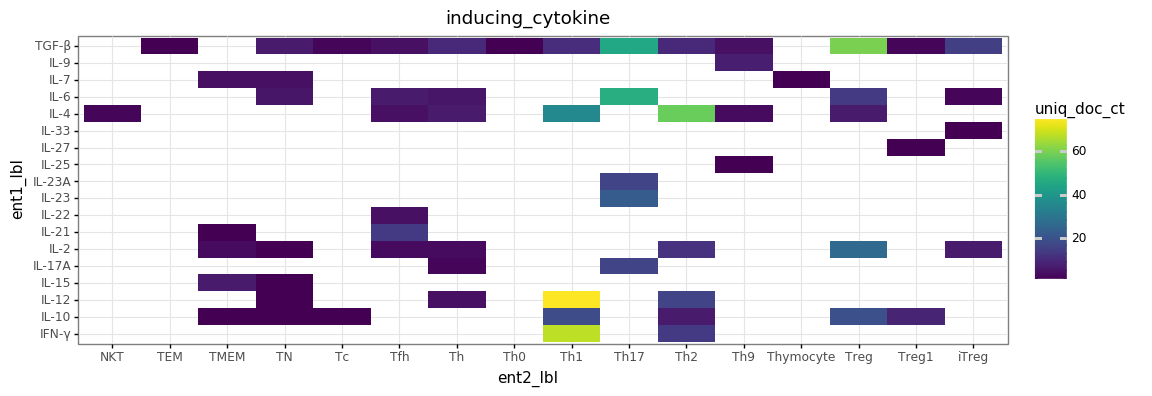

<ggplot: (315391885)>

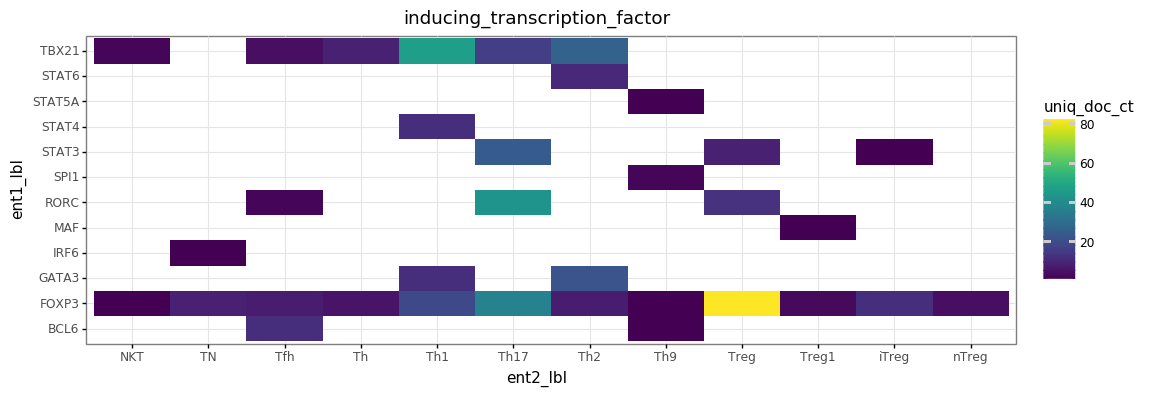

<ggplot: (347641243)>

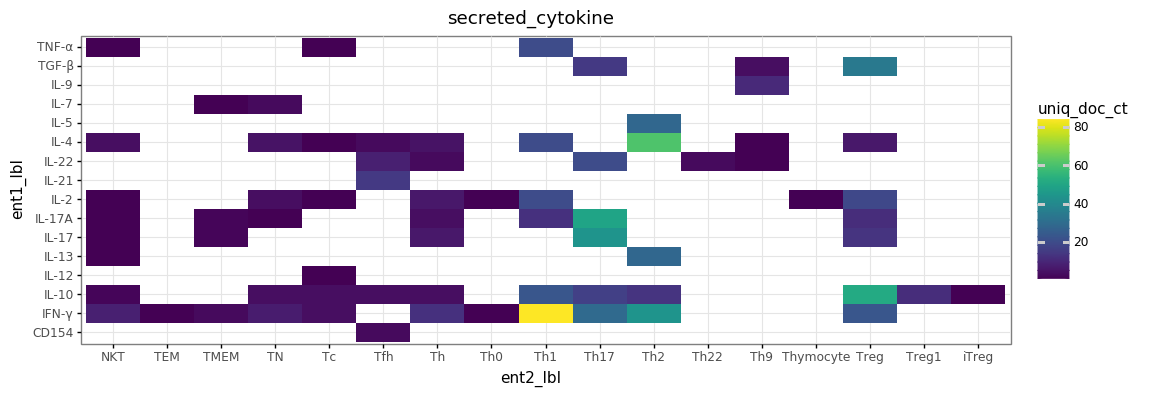

<ggplot: (348494207)>

In [158]:
for k, g in dfp.query('uniq_doc_ct >= 3').groupby('type'):
    p = (
        pn.ggplot(
            g.groupby('ent2_lbl').apply(
                lambda g: g.sort_values('uniq_doc_ct', ascending=False)
                .assign(rank=np.arange(1, len(g)+1)).head(25)
            ),
            pn.aes(x='ent2_lbl', y='ent1_lbl', fill='uniq_doc_ct')
        ) + 
        pn.geom_tile() +
        pn.ggtitle(k) +
        pn.theme_bw() + 
        pn.theme(figure_size=(12, 4))
    )
    display(p)

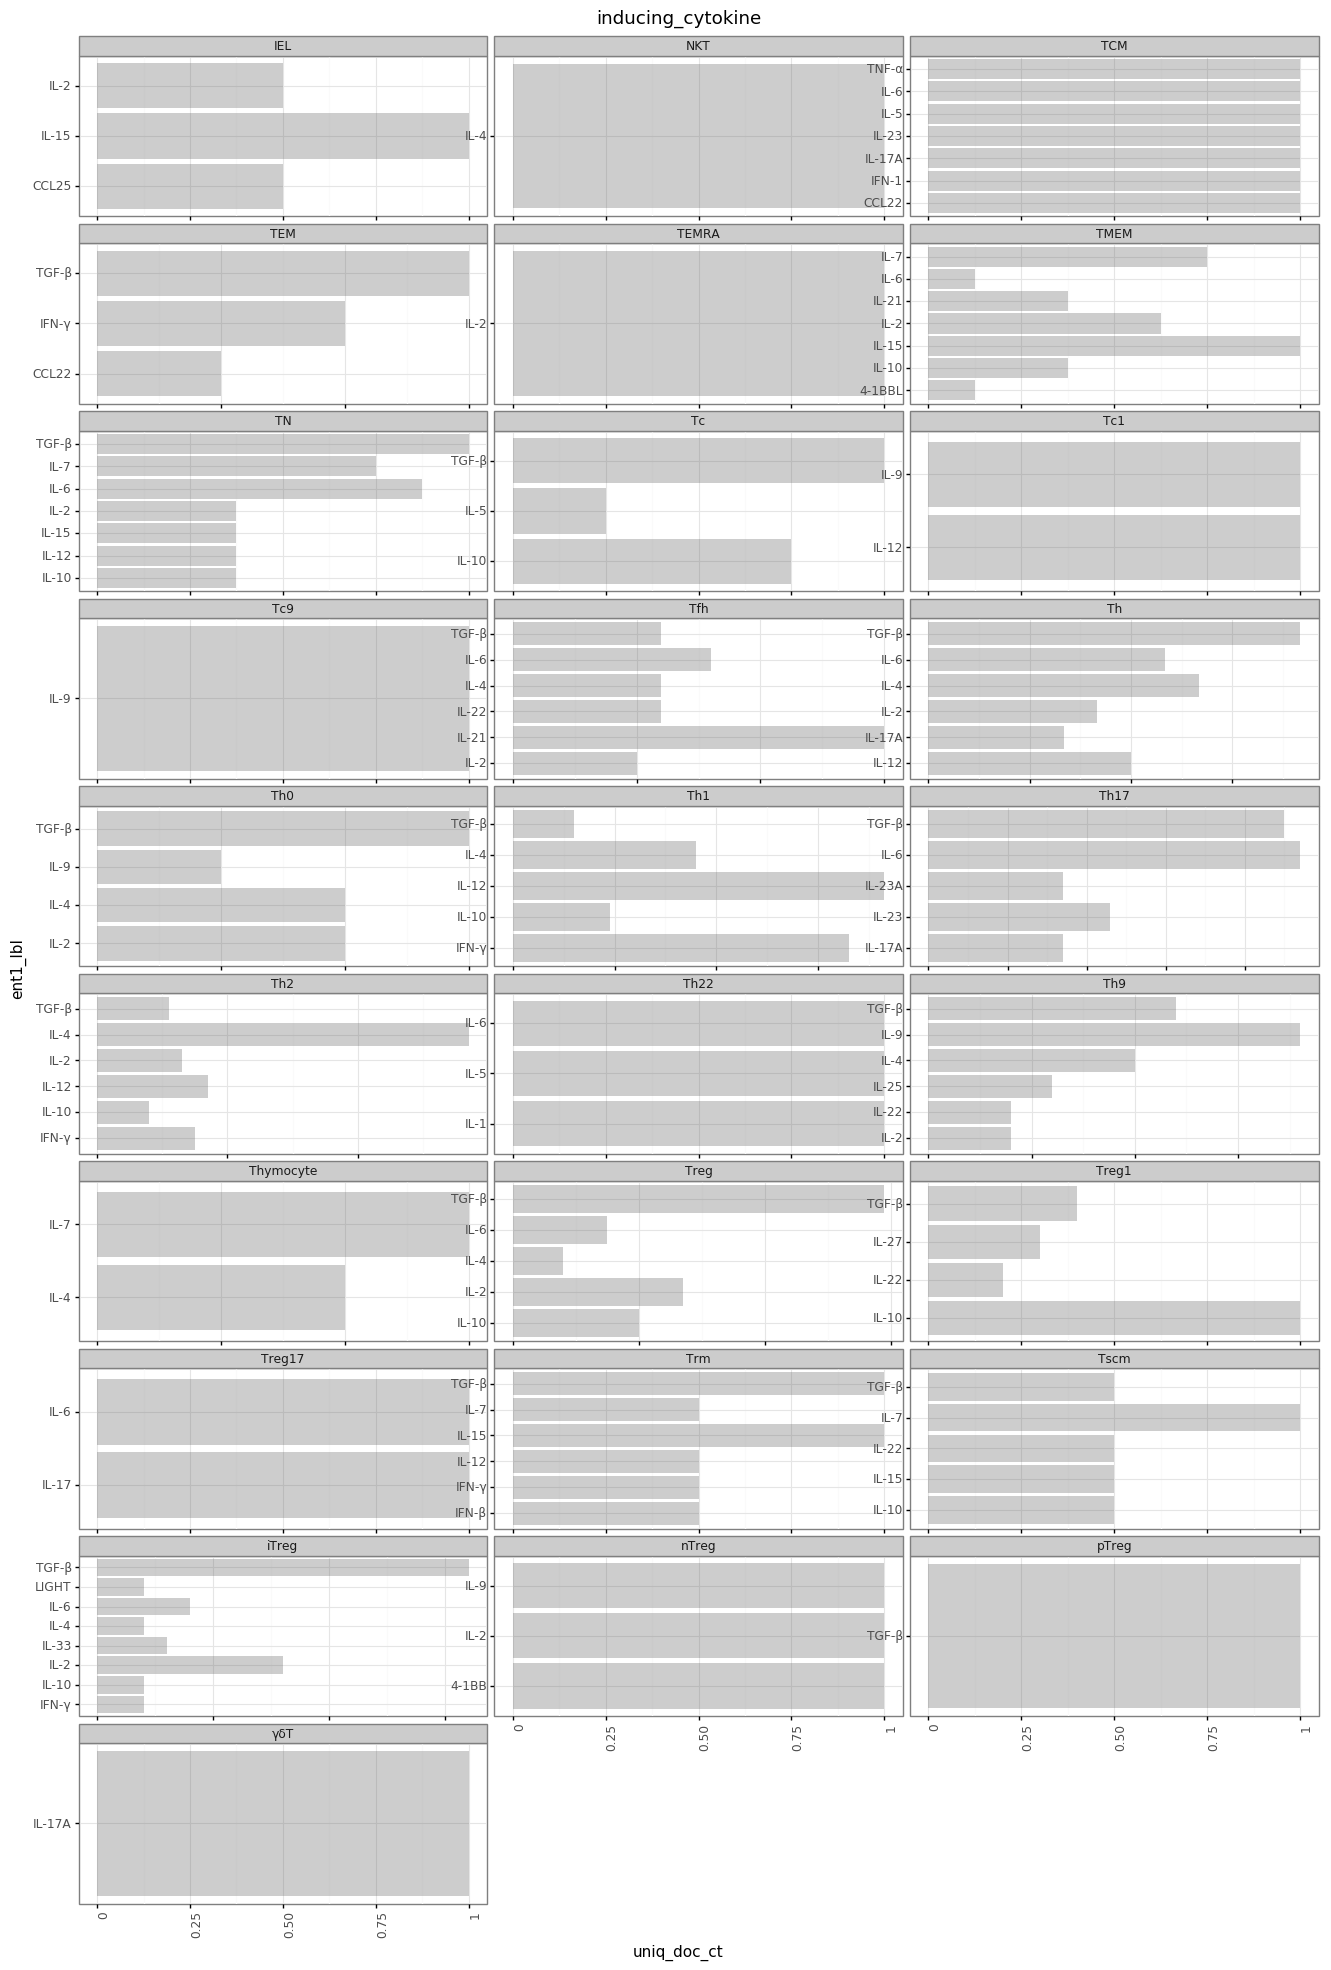

<ggplot: (-9223372036503739739)>

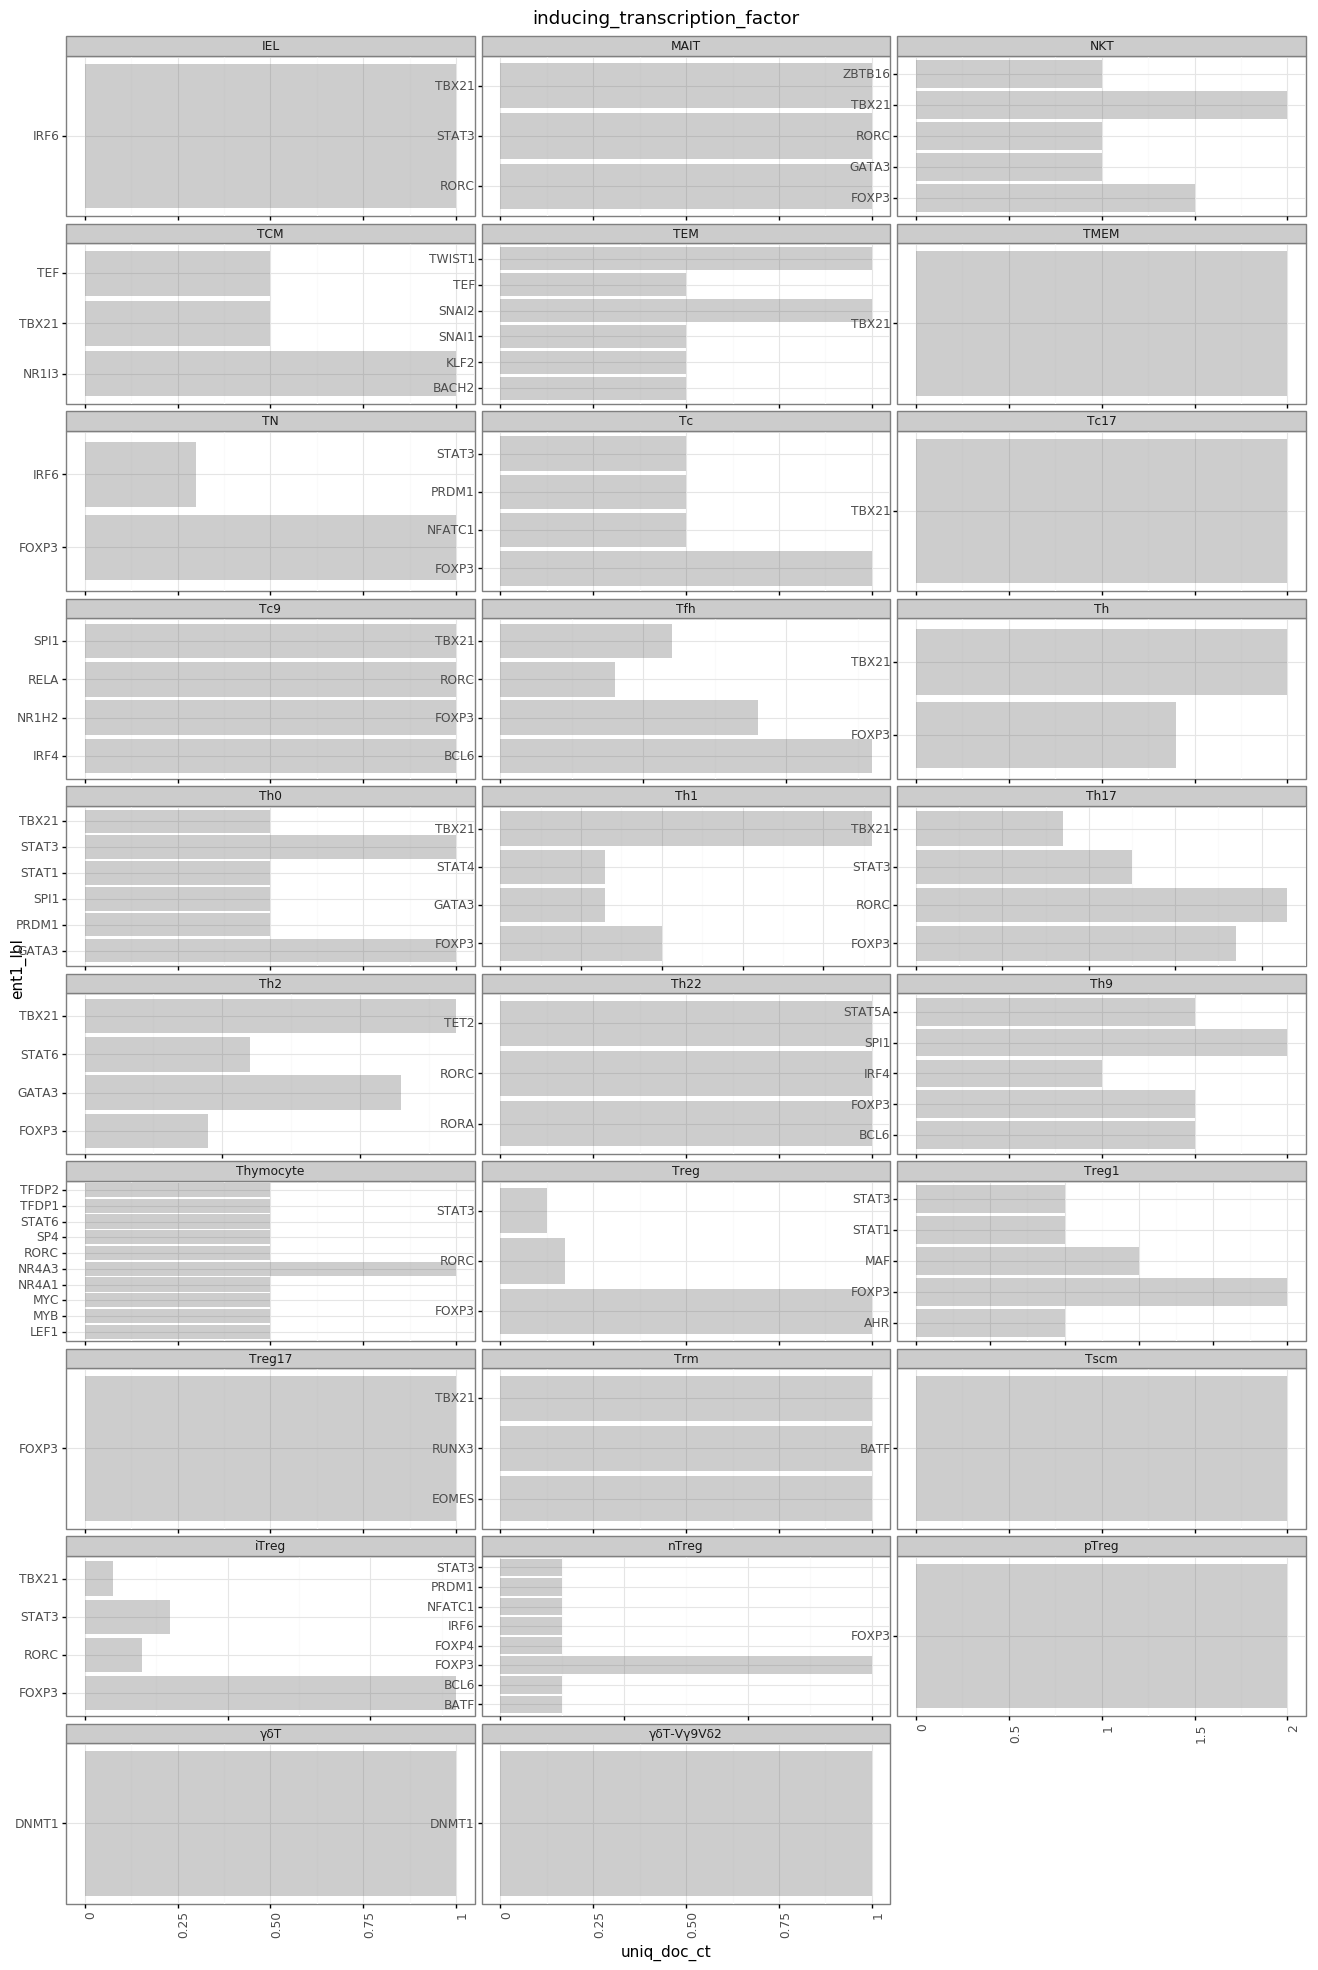

<ggplot: (349800547)>

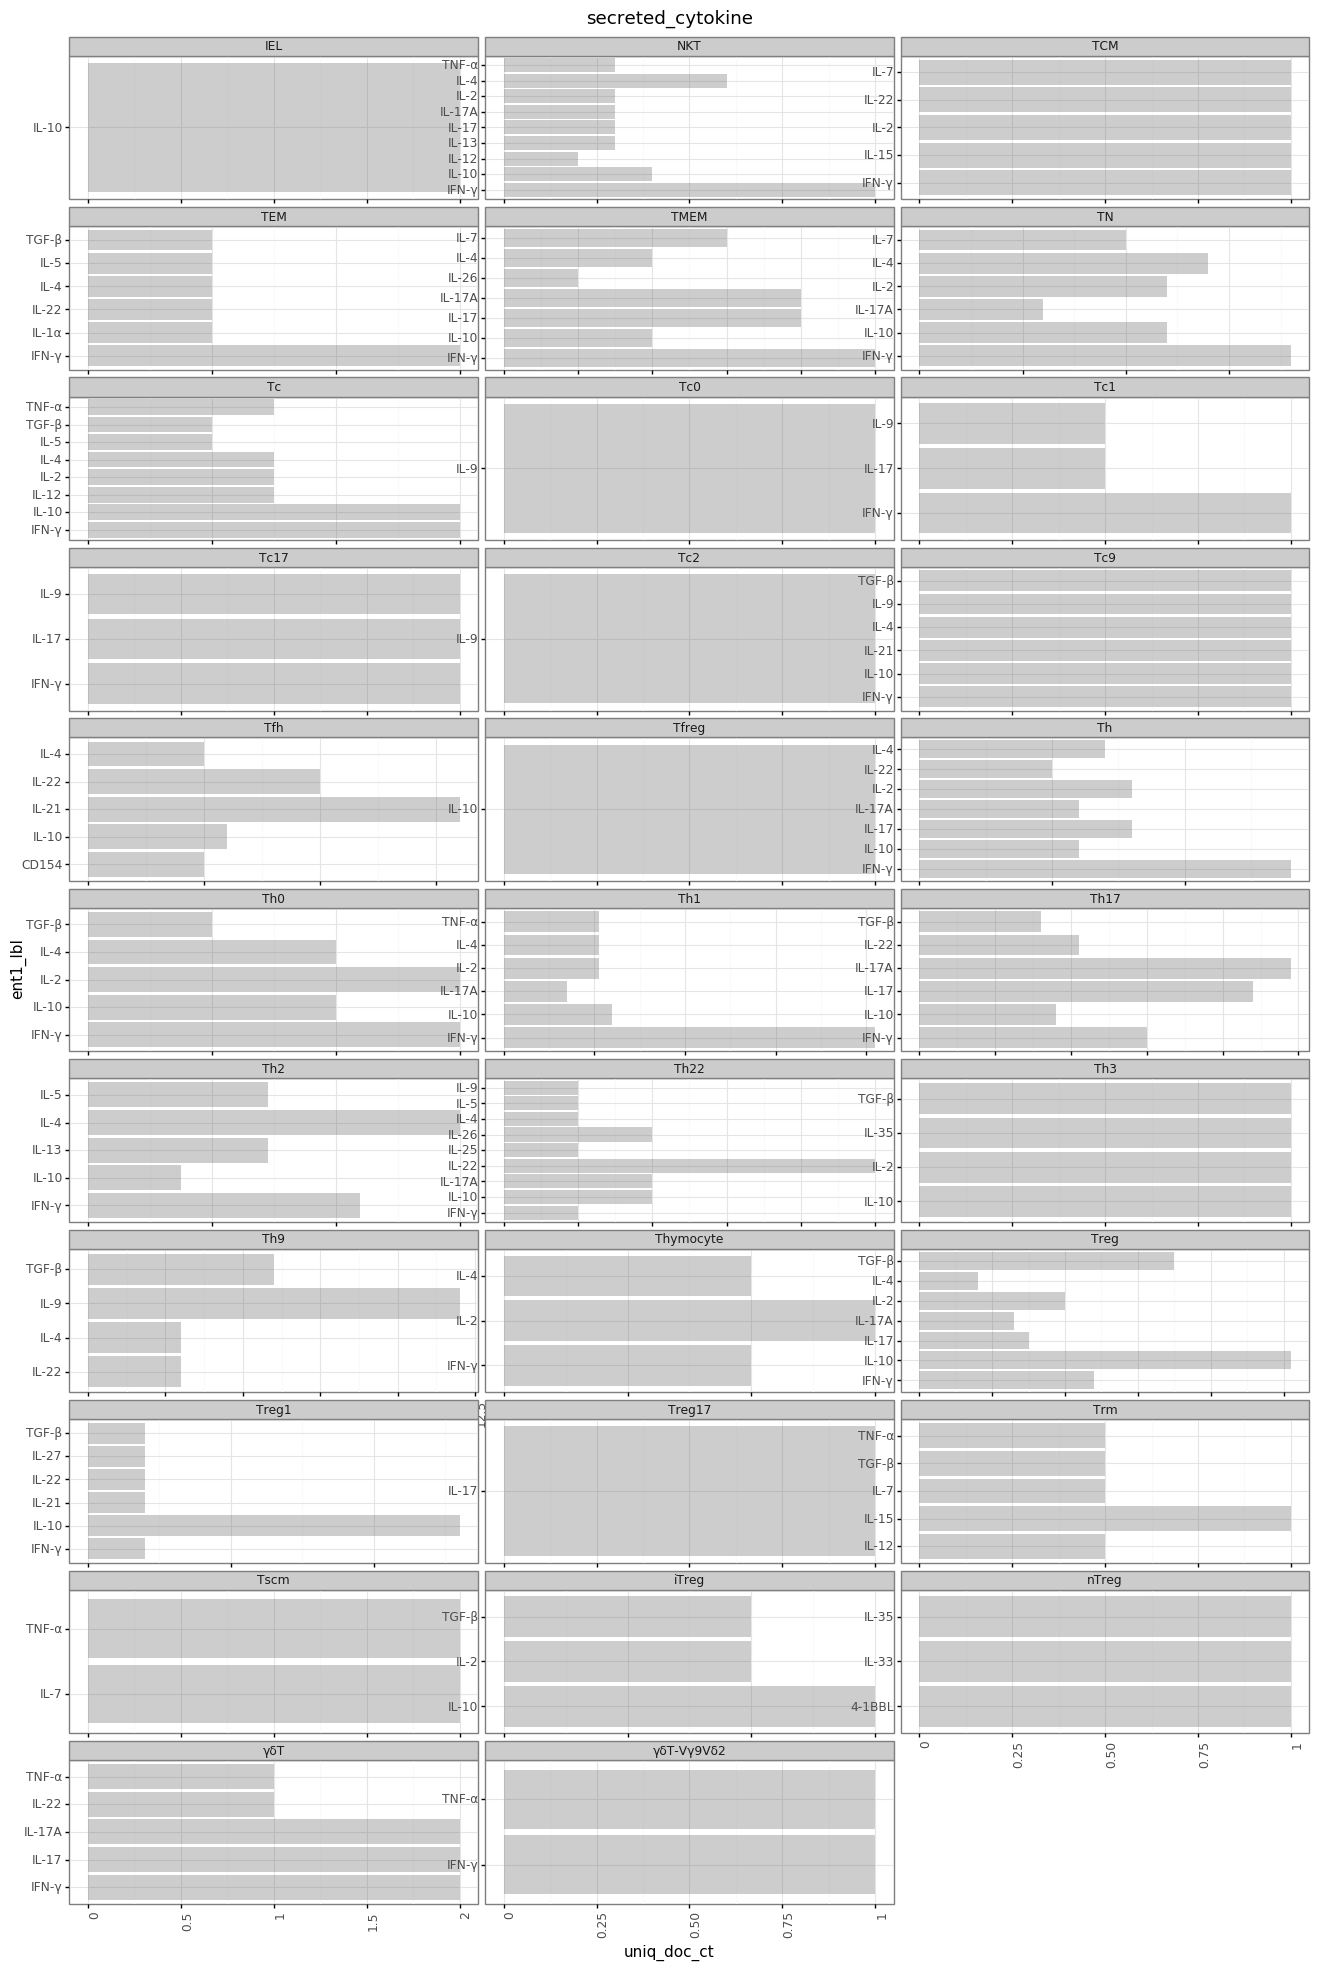

<ggplot: (350979150)>

In [160]:
for k, g in dfp.groupby('type'):
    p = (
        pn.ggplot(g, pn.aes(x='ent1_lbl', y='uniq_doc_ct')) + 
        pn.geom_bar(stat='identity', alpha=.3) +
        pn.facet_wrap('~ ent2_lbl', scales='free', ncol=3, shrink=False) + 
        pn.labs(title=k) + 
        pn.coord_flip() +
        pn.theme_bw() +
        pn.theme(
            axis_text_x = pn.element_text(angle = 90, hjust = 0),
            figure_size=(16, 24)
        )
    )
    display(p)

### Export Candidates to BRAT

In [41]:
%run ../src/brat.py
collection_dir = osp.join(os.environ['REPO_DATA_DIR'], 'brat', 'viz', 'train_01')
corpus_docs_dir = osp.join(os.environ['DATA_DIR'], 'articles', 'corpus', 'corpus_00', 'links')
collection_dir, corpus_docs_dir

('/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/brat/viz/train_01',
 '/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/corpus/corpus_00/links')

<Figure size 432x288 with 0 Axes>

In [42]:
def relation_type_fn(c, i, ents):
    proba = Y[i] 
    if proba < .2:
        return c.type + '_low'
    if proba < .8:
        return c.type + '_mid'
    return c.type + '_high'

def text_loader_fn(doc_id):
    with open(osp.join(corpus_docs_dir, doc_id + '.txt')) as fd:
        return fd.read()

In [44]:
bcol = snorkel_candidates_to_brat_collection(
    X, candidate_class.subclass, text_loader_fn, relation_type_fn=relation_type_fn)

In [45]:
bcol.export(collection_dir, styles={
    candidate_class.field + '_low': 'color:red',
    candidate_class.field + '_mid': 'color:orange',
    candidate_class.field + '_high': 'color:green'
}, include_entity_text=False)